In [1]:
from facenet_pytorch import MTCNN
import cv2
from PIL import Image
import torchvision
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
from torchvision import transforms
import numpy as np
import os
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.tensorboard import SummaryWriter
from facenet_pytorch import InceptionResnetV1
from torch import optim
from facenet_pytorch import fixed_image_standardization, training
from torch.utils.data import DataLoader

In [2]:
class CustomImageDataset(Dataset):

    def __init__(self, csv_file, root_dir, transform=ToTensor()):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dira (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.landmarks_frame.iloc[idx, 0])
        image = cv2.imread(img_name)
        # image = image.view((224,224,3))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # image = cv2.equalizeHist(image)
        image = Image.fromarray(image)
        # print(type(image))
        # # image = np.transpose(image,(1,2,0)) 
        label = self.landmarks_frame.iloc[idx, 1]
        label = np.array(label)
        if self.transform:
            image = self.transform(image)
        return image,label

In [3]:
from facenet_pytorch import fixed_image_standardization, training
preprocessing = transforms.Compose([
    np.float32,
    transforms.ToTensor(),
    transforms.Resize((224,224)),
    fixed_image_standardization
])

trainset = CustomImageDataset(csv_file = 'train_new.csv',
                              root_dir='crop-mask-aug/train/',
                             transform = preprocessing)

In [4]:
from torch.utils.data import DataLoader
trainloader = DataLoader(trainset, batch_size=8,
                        shuffle=True, num_workers=4)

In [5]:
testset = CustomImageDataset(csv_file = 'test.csv',
                              root_dir='crop-mask-face/test/',
                             transform = preprocessing)
testloader = DataLoader(testset, batch_size=8,
                        shuffle=True, num_workers=4)
valset = CustomImageDataset(csv_file = 'val.csv',
                              root_dir='crop-mask-face/val/',
                             transform = preprocessing)
valloader = DataLoader(valset, batch_size=8,
                        shuffle=True, num_workers=4)

In [6]:
from torchvision.models import vgg16
model = vgg16(pretrained = True, progress = True)

In [7]:
model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [9]:
from torch import nn
for param in model.parameters():
    param.requires_grad = False
# class net(nn.Module):
#     def __init__(self):
#         super(net, self).__init__()
#         self.fc = nn.Linear(4096, 50)
    
#     def forward(self, x):
#         x = self.fc(x)
#         return x
#model.classifier._modules['6'] = nn.Linear(in_features=4096, out_features=50, bias=True)
model.classifier = nn.Sequential(
  nn.Linear(in_features=25088, out_features=4096, bias=True),
  nn.BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
  nn.ReLU(inplace=True),
  nn.Linear(in_features=4096, out_features=1024, bias=True),
  nn.BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
  nn.ReLU(inplace=True),
  nn.Linear(in_features=1024, out_features=50, bias=True)
)

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# layer = [child for child in model.children()]
# for i in range(len(layer)):
#     if i != 2:
#         for param in layer[i].parameters():
#             param.requires_grad = False
#     if i == 2:
#         for j in range(len(layer[2])):
#             child = layer[2][j]
#             for param in child.parameters():
#                 param.requires_grad = True
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [11]:
from torch import optim
# for child in model.children():
#     if child != model.fc:
#         for param in child.parameters():
#             param.requires_grad = False
#     if child == model.fc:
#         for param in child.parameters():
#             param.requires_grad = True  
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

In [12]:
for epoch in range(3):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # print every 100 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 100:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,   100] loss: 4.130
[1,   200] loss: 2.987
[1,   300] loss: 2.288
[1,   400] loss: 1.819
[1,   500] loss: 1.470
[1,   600] loss: 1.299
[2,   100] loss: 0.540
[2,   200] loss: 0.528
[2,   300] loss: 0.480
[2,   400] loss: 0.368
[2,   500] loss: 0.426
[2,   600] loss: 0.464
[3,   100] loss: 0.255
[3,   200] loss: 0.208
[3,   300] loss: 0.192
[3,   400] loss: 0.206
[3,   500] loss: 0.244
[3,   600] loss: 0.284
Finished Training


In [13]:
# for param in model.parameters():
#     param.requires_grad = True
for child in model.children():
    for param in child.parameters():
        param.requires_grad = True
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [15]:
#define where to record train loss, valid loss and valid accuracy of each epoch
train_loss = []
valid_loss = []
valid_acc = []
min_val_loss = 1e10
#imporve the batch size
for epoch in range(30):  # loop over the dataset multiple times

    train_running_loss = 0.0
    valid_running_loss = 0.0
    valid_rc = 0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        train_running_loss += loss.item()
        if i % 100 == 99:    # print every 1000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] finished!')
            
    #save the model with smallest loss on validation set
    model.eval()
    for i, data in enumerate(valloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # forward + backward + optimize
        outputs = model(inputs)
        _,predicted = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        # statistics
        valid_running_loss += loss.item()
        valid_rc += (predicted == labels).sum().item()
    train_loss.append(train_running_loss / len(trainloader))
    valid_loss.append(valid_running_loss/len(valloader))
    #compare validation loss, save the parameters corresponds to the minmimum valid loss epoch
    if valid_loss[-1]<min_val_loss:
        torch.save(model.state_dict(),'./savedmodels/model_vgg_parameter.pth')
        min_val_loss = valid_loss[-1]
    valid_acc.append(valid_rc/len(valset))
    #print out train loss and validation loss and accuracy of each epoch
    print(f'Epoch: {epoch + 1}, Train Loss: {train_running_loss / len(trainloader):.3f}')
    print(f'Epoch: {epoch + 1}, Validation Loss: {valid_running_loss / len(valloader):.3f}, Validation Accuracy: {valid_rc/len(valset):.2f}')
    train_running_loss = 0.0
    valid_running_lossa = 0.0
    valid_rc = 0

print('Finished Training')

[1,   100] finished!
[1,   200] finished!
[1,   300] finished!
[1,   400] finished!
[1,   500] finished!
[1,   600] finished!
Epoch: 1, Train Loss: 2.576
Epoch: 1, Validation Loss: 3.156, Validation Accuracy: 0.28
[2,   100] finished!
[2,   200] finished!
[2,   300] finished!
[2,   400] finished!
[2,   500] finished!
[2,   600] finished!
Epoch: 2, Train Loss: 1.637
Epoch: 2, Validation Loss: 1.680, Validation Accuracy: 0.60
[3,   100] finished!
[3,   200] finished!
[3,   300] finished!
[3,   400] finished!
[3,   500] finished!
[3,   600] finished!
Epoch: 3, Train Loss: 0.768
Epoch: 3, Validation Loss: 1.506, Validation Accuracy: 0.63
[4,   100] finished!
[4,   200] finished!
[4,   300] finished!
[4,   400] finished!
[4,   500] finished!
[4,   600] finished!
Epoch: 4, Train Loss: 0.372
Epoch: 4, Validation Loss: 1.959, Validation Accuracy: 0.60
[5,   100] finished!
[5,   200] finished!
[5,   300] finished!
[5,   400] finished!
[5,   500] finished!
[5,   600] finished!
Epoch: 5, Train Lo

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


True Label :  5 Prediction :  0 , Score:  0.065585725


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


True Label :  23 Prediction :  7 , Score:  7.885947
True Label :  41 Prediction :  46 , Score:  8.289965
True Label :  40 Prediction :  32 , Score:  4.3212185
True Label :  2 Prediction :  10 , Score:  0.004325963


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


True Label :  43 Prediction :  0 , Score:  0.5566233


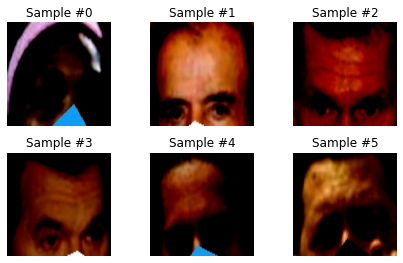

In [16]:
preprocessing = transforms.Compose([
    np.float32,
    transforms.ToTensor(),
    transforms.Resize((160,160)),
    fixed_image_standardization
])
testset = CustomImageDataset(csv_file = 'test.csv',
                              root_dir='crop-mask-face/test/',
                             transform = preprocessing)
testloader = DataLoader(testset, batch_size=1,
                        shuffle=True, num_workers=0)
sample = 0 
with torch.no_grad():
    for i, (inputs, classes) in enumerate(testloader):
        inputs = inputs.to(device)
        # print(inputs.shape)
        classes = classes.to(device)
        outputs = model(inputs)
        ps = torch.exp(outputs)
        topk, topclass = ps.topk(1, dim=1)
        if sample < 6:
            if classes[0].item() != topclass.cpu().numpy()[0][0]:
                print('True Label : ', classes[0].item(), "Prediction : ", topclass.cpu().numpy()[0][0], ", Score: ", topk.cpu().numpy()[0][0])
                ax = plt.subplot(2, 3, sample + 1)
                plt.tight_layout()
                ax.set_title('Sample #{}'.format(sample))
                ax.axis('off')
                plt.imshow(inputs[0].cpu().permute(1,2,0))
                sample += 1

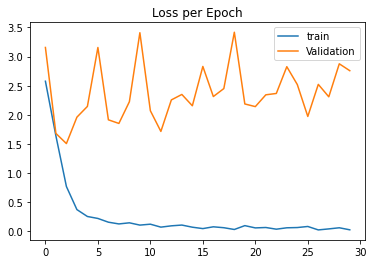

<Figure size 432x288 with 0 Axes>

In [17]:
plt.plot(train_loss,label = "train")
plt.plot(valid_loss,label="Validation")
plt.title("Loss per Epoch")
plt.legend()
plt.show()
plt.savefig('VGG16.png')